In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from cellpose import models

In [4]:
model = models.Cellpose(model_type="nuclei", gpu=True)

>>>> using CPU


In [5]:
img = skimage.io.imread('/home/zach/Desktop/Pos58_processed.tif')
imgs = [img]

Finding the best preprocessing
0) Training data
    Regions {Sparse, Medium and Dense}
    Cell pose on and fix manually (perfect labels)
1) Preprocessing
    Decovolution
    Background Subtraction
    Wavelet transform
    Blurring
    Downsampling
    Sobel Transform
2) Segmentation
3) Metric for accuracy
    % of pixels are correct
    
Full Scale
1) Numpy (working with arrays/imgs)
2) Metadata (loading images)
3) Preprocessing
4) Segmentation
5) Fixing mistakes manually


In [6]:
masks,flows,styles,diams = model.eval(imgs,diameter=90.0,channels = [0,0],flow_threshold=1,cellprob_threshold=0)

processing 1 images


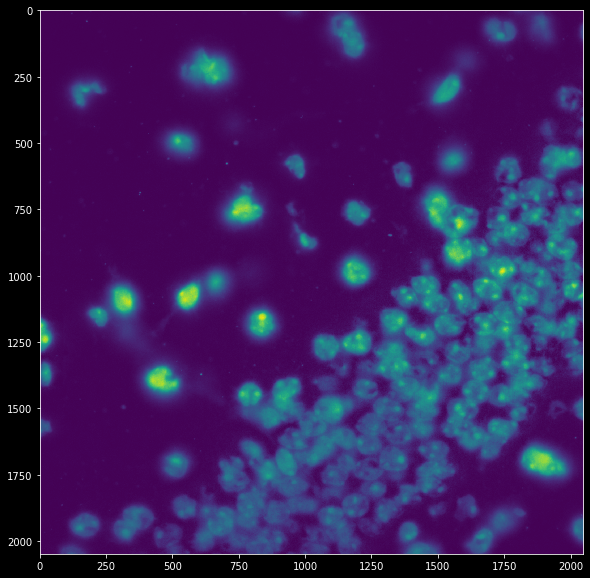

In [7]:
plt.figure(figsize=[10,10])
plt.imshow(imgs[0])
plt.show()

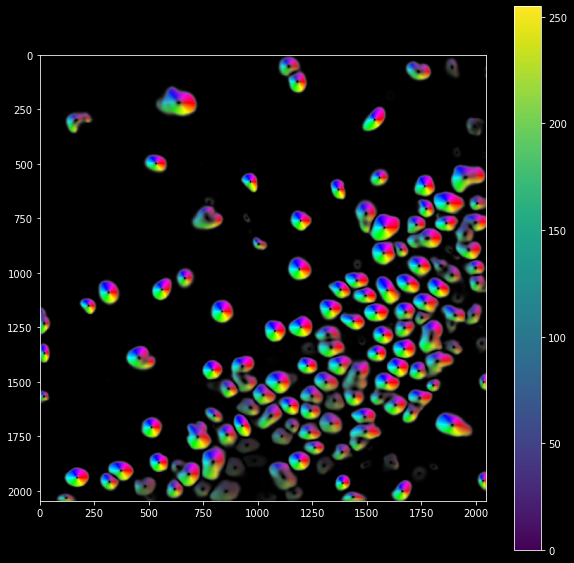

In [8]:
img = flows[0][0]
plt.figure(figsize=[10,10])
plt.imshow(img)
plt.colorbar()
plt.show()

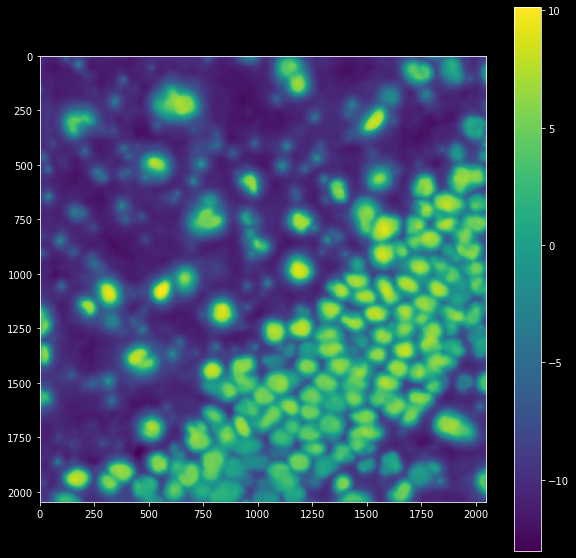

In [9]:
img = flows[0][2]
plt.figure(figsize=[10,10])
plt.imshow(img)
plt.colorbar()
plt.show()

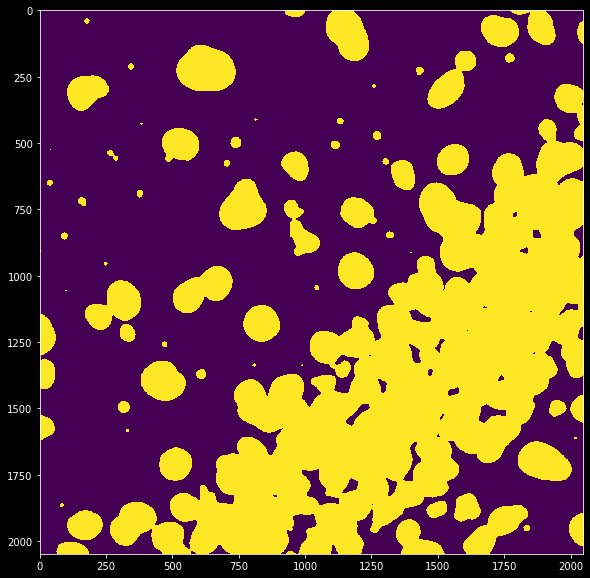

In [14]:
img = flows[0][2]
plt.figure(figsize=[10,10])
plt.imshow(img>-5)
plt.show()

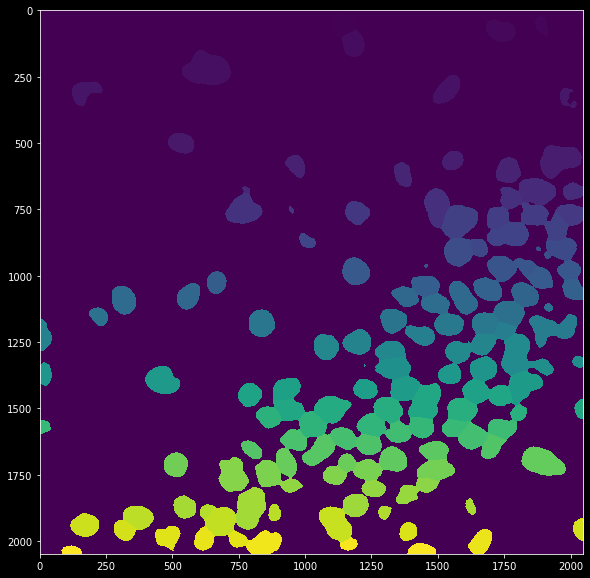

In [11]:
plt.figure(figsize=[10,10])
plt.imshow(masks[0])
plt.show()

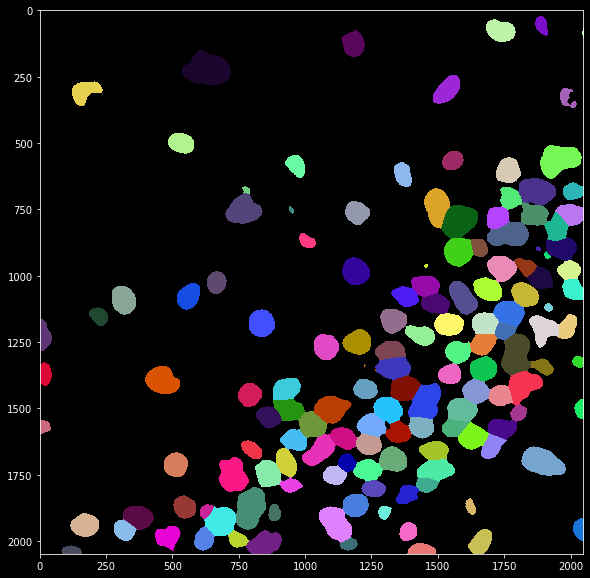

In [13]:
from fish_helpers import *
plt.figure(figsize=[10,10])
plt.imshow(colorize_segmented_image(masks[0]))
plt.show()

In [1]:
from ipypb import ipb
from time import sleep
for i in ipb(range(5)):
    sleep(0.2)

 [████████████████████████████████████████████████████████████] 5/5 [00:01<00:00, 0.20s/it]

In [1]:
from metadata import Metadata
from ipypb import ipb
from scipy.ndimage.filters import gaussian_filter
from cellpose import models
from collections import Counter
from skimage.external import tifffile
import multiprocessing
import os
import numpy as np
import random
out_dir = '/bigstore/Images2020/Zach/Cellpose_Hippocampus_test'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
md_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/'
md = Metadata(md_path)
acqs = [ i for i in md.acqnames if ('hybe' in i)|('nucstain' in i)]
poses = md.image_table[md.image_table.acq.isin(acqs)].Position.unique()
def wrapper(data):
    img = data['img']
    bkg = gaussian_filter(img,40)
    bkg_sub = img-bkg
    z = data['z']
    model = models.Cellpose(model_type="nuclei", gpu=True,batch_size=150)
    masks,flows,styles,diams = model.eval([bkg_sub],diameter=90.0,channels = [0,0],flow_threshold=1, cellprob_threshold=0)
    mask = masks[0].copy()
    for label,num in Counter(mask[mask>0].ravel()).items():
        if num<1000:
            loc = np.where(mask==label)
            x = loc[0]
            y = loc[1]
            masks[0][x,y]=0
    return masks,flows,img,z

for pos in poses:
    if os.path.exists(os.path.join(out_dir,pos)):
        continue
    print(pos)
    acq = [i for i in acqs if 'nucstain' in i]
    stk = md.stkread(Position=pos,Channel='DeepBlue',acq=acq)
    Input = []
    for z in range(stk.shape[2]):
        img = stk[:,:,z]
        Input.append({'img':img,'z':z})

    ncpu = 32
    mask_stk = np.empty(stk.shape)
    with multiprocessing.Pool(ncpu) as ppool:
                sys.stdout.flush()
                for masks,flows,img,z in ipb(ppool.imap(wrapper, Input)):
                    mask_stk[:,:,z] = masks[0]
                ppool.close()
                sys.stdout.flush()

    out_path = os.path.join(out_dir,pos)
    if not os.path.exists(out_path):
        os.mkdir(out_path)

    tifffile.imsave(os.path.join(out_path,'stk.tif'), np.swapaxes(stk,0,2).astype('uint16'))
    tifffile.imsave(os.path.join(out_path,'mask_stk.tif'), np.swapaxes(mask_stk,0,2).astype('uint16'))

Pos2
opening img_Pos2_000000032_000000000_DeepBlue_000_032.tif

KeyboardInterrupt: 

In [1]:
from cellpose import models

In [2]:
model = models.Cellpose(model_type="nuclei",gpu=True)

>>>> using GPU


opening img_Pos111_000000032_000000000_DeepBlue_000_032.tif

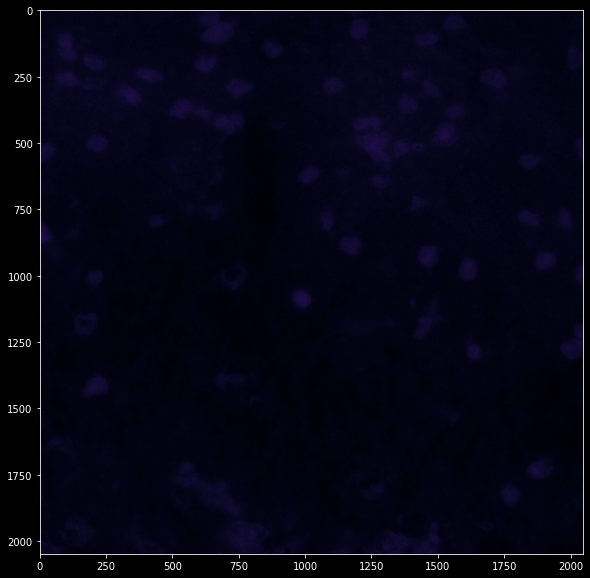

 [############################################################] 0/32 [0<0, 0.00s/it]

>>>> using CPU
processing 1 images


KeyboardInterrupt: 

In [3]:
from metadata import Metadata
from ipypb import ipb
from scipy.ndimage.filters import gaussian_filter
from cellpose import models
from skimage.external import tifffile
from collections import Counter
import multiprocessing
import os
import numpy as np
import sys
import time
import random
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
start = time.time()
out_dir = '/bigstore/Images2020/Zach/Cellpose_Hippocampus_test'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
md_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/'
md = Metadata(md_path)
acqs = [ i for i in md.acqnames if ('hybe' in i)|('nucstain' in i)]
poses = md.image_table[md.image_table.acq.isin(acqs)].Position.unique()
pos = random.choice(poses)
while os.path.exists(os.path.join(out_dir,pos)):
    pos = random.choice(poses)
acq = [i for i in acqs if 'nucstain' in i]
stk = md.stkread(Position=pos,Channel='DeepBlue',acq=acq)
plt.figure(figsize=[10,10])
plt.imshow(stk[:,:,10],cmap='inferno')
plt.show()
Input = []
for z in range(stk.shape[2]):
    img = stk[:,:,z]
    Input.append({'img':img,'z':z})
    
def wrapper(data):
    img = data['img']
    bkg = gaussian_filter(img,40)
    bkg_sub = img/bkg
    z = data['z']
    model = models.Cellpose(model_type="nuclei",gpu=True)
    masks,flows,styles,diams = model.eval([bkg_sub],diameter=90.0,channels = [0,0],flow_threshold=1, cellprob_threshold=0)
    mask = masks[0].copy()
    for label,num in Counter(mask[mask>0].ravel()).items():
        if num<1000:
            loc = np.where(mask==label)
            x = loc[0]
            y = loc[1]
            masks[0][x,y]=0
    return masks,flows,bkg_sub,z

ncpu = 1
mask_stk = np.empty(stk.shape)
flow_stk  = np.empty([2048,2048,3,stk.shape[2]])
prob_stk = np.empty(stk.shape)
with multiprocessing.Pool(ncpu) as ppool:
            sys.stdout.flush()
            for masks,flows,img,z in ipb(ppool.imap(wrapper, Input),len(Input)):
                mask_stk[:,:,z] = masks[0]
                flow_stk[:,:,:,z] = flows[0][0]
                prob_stk[:,:,z] = flows[0][2]
            ppool.close()
            sys.stdout.flush()
            
out_path = os.path.join(out_dir,pos)
if not os.path.exists(out_path):
    os.mkdir(out_path)

tifffile.imsave(os.path.join(out_path,'stk.tif'), np.swapaxes(stk,0,2).astype('uint16'))
tifffile.imsave(os.path.join(out_path,'mask_stk.tif'), np.swapaxes(mask_stk,0,2).astype('uint16'))
tifffile.imsave(os.path.join(out_path,'prob_stk.tif'), np.swapaxes(prob_stk,0,2).astype('uint16'))
end = time.time()
print(end-start)

opening img_Pos217_000000032_000000000_DeepBlue_000_032.tif

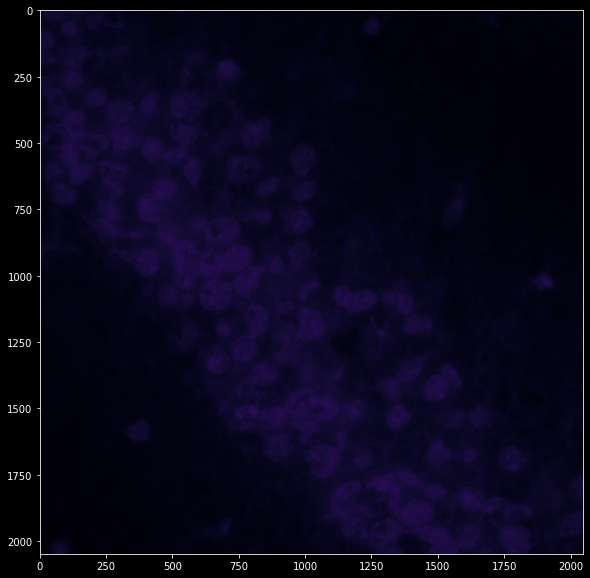

>>>> using GPU
processing 32 images


  3%|▎         | 1/32 [00:37<19:15, 37.28s/it]

In [ ]:
from metadata import Metadata
from ipypb import ipb
from scipy.ndimage.filters import gaussian_filter
from cellpose import models
from skimage.external import tifffile
from collections import Counter
import multiprocessing
import os
import numpy as np
import sys
import time
import random
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
start = time.time()
out_dir = '/bigstore/Images2020/Zach/Cellpose_Hippocampus_test'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
md_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/'
md = Metadata(md_path)
acqs = [ i for i in md.acqnames if ('hybe' in i)|('nucstain' in i)]
poses = md.image_table[md.image_table.acq.isin(acqs)].Position.unique()
pos = random.choice(poses)
while os.path.exists(os.path.join(out_dir,pos)):
    pos = random.choice(poses)
acq = [i for i in acqs if 'nucstain' in i]
stk = md.stkread(Position=pos,Channel='DeepBlue',acq=acq)
plt.figure(figsize=[10,10])
plt.imshow(stk[:,:,10],cmap='inferno')
plt.show()
imgs = []
for z in range(stk.shape[2]):
    img = stk[:,:,z]
    imgs.append(img)
mask_stk = np.empty(stk.shape)
model = models.Cellpose(model_type="nuclei",gpu=True,batch_size=600)
masks,flows,styles,diams = model.eval(imgs,diameter=90.0,channels = [0,0],flow_threshold=1, cellprob_threshold=0)
for z in range(len(masks)):
    mask = masks[z].copy()
    for label,num in Counter(mask[mask>0].ravel()).items():
        if num<1000:
            loc = np.where(mask==label)
            x = loc[0]
            y = loc[1]
            mask[x,y]=0
    mask_stk[:,:,z] = mask
out_path = os.path.join(out_dir,pos)
if not os.path.exists(out_path):
    os.mkdir(out_path)

tifffile.imsave(os.path.join(out_path,'stk.tif'), np.swapaxes(stk,0,2).astype('uint16'))
tifffile.imsave(os.path.join(out_path,'mask_stk.tif'), np.swapaxes(mask_stk,0,2).astype('uint16'))
end = time.time()
print(end-start)

In [2]:
from metadata import Metadata
from ipypb import ipb
from scipy.ndimage.filters import gaussian_filter
from cellpose import models
from skimage.external import tifffile
from collections import Counter
import multiprocessing
import os
import numpy as np
import sys
import time
import random
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
out_dir = '/bigstore/Images2020/Zach/Cellpose_Hippocampus_test'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
md_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/'
md = Metadata(md_path)
acqs = [ i for i in md.acqnames if ('hybe' in i)|('nucstain' in i)]
poses = md.image_table[md.image_table.acq.isin(acqs)].Position.unique()
Input = []
used_poses = []
for i in range(100):
    pos = random.choice(poses)
    while (os.path.exists(os.path.join(out_dir,pos)))|(pos in used_poses):
        pos = random.choice(poses)
    used_poses.append(pos)
    acq = [i for i in acqs if 'nucstain' in i]
    stk = md.stkread(Position=pos,Channel='DeepBlue',acq=acq)
    Input.append({'stk':stk,'pos_path':os.path.join(out_dir,pos)})

def wrapper(data):
    stk = data['stk']
    pos_path = data['pos_path']
    imgs = []
    for z in range(stk.shape[2]):
        img = stk[:,:,z]
        bkg = gaussian_filter(img,40)
        bkg_sub = img/bkg
        imgs.append(bkg_sub)
    mask_stk = np.empty(stk.shape)
    model = models.Cellpose(model_type="nuclei",gpu=True,batch_size=150)
    masks,flows,styles,diams = model.eval(imgs,diameter=90.0,channels = [0,0],flow_threshold=1, cellprob_threshold=0)
    for z in range(len(masks)):
        mask = masks[z].copy()
        for label,num in Counter(mask[mask>0].ravel()).items():
            if num<1000:
                loc = np.where(mask==label)
                x = loc[0]
                y = loc[1]
                mask[x,y]=0
        mask_stk[:,:,z] = mask
    if not os.path.exists(pos_path):
        os.mkdir(pos_path)
    tifffile.imsave(os.path.join(pos_path,'stk.tif'), np.swapaxes(stk,0,2).astype('uint16'))
    tifffile.imsave(os.path.join(pos_path,'mask_stk.tif'), np.swapaxes(mask_stk,0,2).astype('uint16'))
    return None
ncpu = 6
with multiprocessing.Pool(ncpu) as ppool:
    sys.stdout.flush()
    for i in ipb(ppool.imap(wrapper, Input),len(Input)):
        a=1
    ppool.close()
    sys.stdout.flush()

opening img_Pos100_000000032_000000000_DeepBlue_000_032.tif

 [███#########################################################] 5/100 [01:36:22<01:47, 1156.35s/it]

>>>> using GPU
>>>> using GPU
processing 32 images
processing 32 images
>>>> using GPU
processing 32 images
>>>> using GPU


  0%|          | 0/32 [00:00<?, ?it/s]

processing 32 images
>>>> using GPU


  0%|          | 0/32 [00:00<?, ?it/s]

processing 32 images
>>>> using GPU


  0%|          | 0/32 [00:00<?, ?it/s]

processing 32 images


 94%|█████████▍| 30/32 [1:13:12<03:15, 97.86s/it] 

>>>> using GPU
processing 32 images


  9%|▉         | 3/32 [06:07<1:01:47, 127.83s/it]]

>>>> using GPU
processing 32 images
>>>> using GPU
processing 32 images


 22%|██▏       | 7/32 [13:12<43:23, 104.14s/it]  ]

>>>> using GPU
processing 32 images


 22%|██▏       | 7/32 [13:37<43:38, 104.74s/it]

>>>> using GPU
processing 32 images


  6%|▋         | 2/32 [01:39<24:56, 49.89s/it] ]

>>>> using GPU
processing 32 images


 84%|████████▍ | 27/32 [1:04:09<11:52, 142.56s/it]

Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
  File "/home/zach/miniconda3/envs/cellpose_v1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/zach/miniconda3/envs/cellpose_v1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/cellpose_v1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/zach/miniconda3/envs/cellpose_v1/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/zach/miniconda3/envs/cellpose_v1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-1cde516940f3>", line 44, in wrapper
    masks,flows,styles,diams = model.eval(imgs,diamet

KeyboardInterrupt: 

In [12]:
from skimage.external import tifffile
import os
out_dir = '/bigstore/Images2020/Zach/Cellpose_Hippocampus_test'
for pos in os.listdir(out_dir):
    for file in os.listdir(os.path.join(out_dir,pos)):
        temp = tifffile.imread(os.path.join(out_dir,pos,file))
        tifffile.imsave(os.path.join(out_dir,pos,file), temp.astype('uint16'))

In [5]:
from skimage.external import tifffile
import numpy as np
import os
out_dir = '/bigstore/Images2020/Zach/Cellpose_Hippocampus_test'
for pos in os.listdir(out_dir):
    mask = tifffile.imread(os.path.join(out_dir,pos,'mask_stk.tif'))
    mask =  np.swapaxes(mask,0,2)
    break

In [6]:
mask.shape

(2048, 2048, 32)

In [18]:
from skimage.measure import regionprops
import pandas as pd
xi = []
yi = []
zi = []
label_id = []
for z in range(mask.shape[2]):
    mask_2d = mask[:,:,z]
    for region in regionprops(mask_2d):
        xy = region.centroid
        xi.append(xy[0])
        yi.append(xy[1])
        zi.append(z)
        label_id.append(region.label)
mask_df = pd.DataFrame()
mask_df['label_id'] = label_id
mask_df['xi'] = xi
mask_df['yi'] = yi
mask_df['zi'] = zi
mask_df

,label_id,xi,yi,zi
0,1,11.375583,1384.590202,0
1,2,26.687678,1142.266407,0
2,3,29.755199,139.749934,0
3,4,63.080852,1275.495769,0
4,5,89.963066,1763.370858,0
...,...,...,...,...
5080,132,1979.490770,487.434072,31
5081,133,1996.407295,699.347807,31
5082,134,1998.879258,201.420681,31
5083,135,2024.214323,317.789555,31


In [19]:
pixel_size = 0.104
step_size = 0.4
mask_df['xc'] = mask_df['xi']*pixel_size
mask_df['yc'] = mask_df['yi']*pixel_size
mask_df['zc'] = mask_df['zi']*step_size

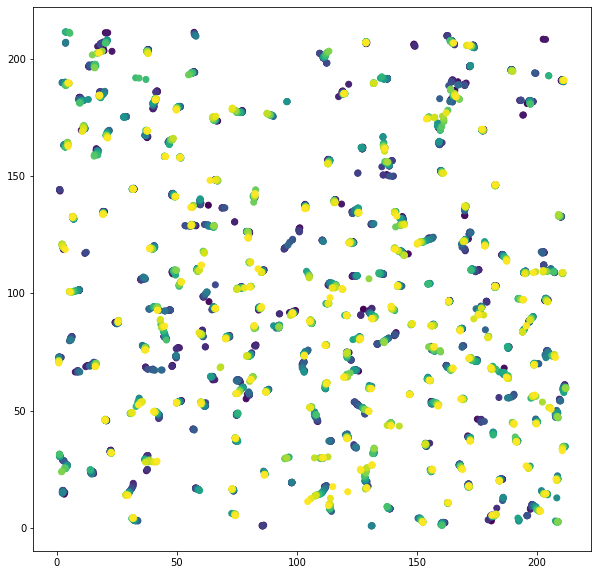

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.scatter(mask_df['xc'],mask_df['yc'],c=mask_df['zc'])
plt.show()

In [23]:
mask_df.drop(columns = [i for i in mask_df.columns if not i in ['xc','yc','zc']])

,xc,yc,zc
0,1.183061,143.997381,0.0
1,2.775519,118.795706,0.0
2,3.094541,14.533993,0.0
3,6.560409,132.651560,0.0
4,9.356159,183.390569,0.0
...,...,...,...
5080,205.867040,50.693143,12.4
5081,207.626359,72.732172,12.4
5082,207.883443,20.947751,12.4
5083,210.518290,33.050114,12.4


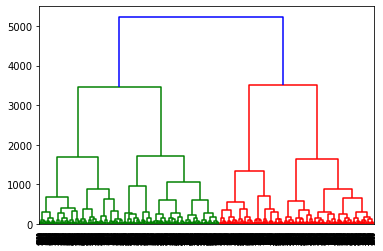

In [24]:
import scipy.cluster.hierarchy as shc
coord = mask_df.drop(columns = [i for i in mask_df.columns if not i in ['xc','yc','zc']])
dend = shc.dendrogram(shc.linkage(coord, method='ward'))

In [25]:
linkage = shc.linkage(coord)

In [30]:
from sklearn.cluster import DBSCAN

In [33]:
coord = mask_df.drop(columns = [i for i in mask_df.columns if not i in ['xc','yc','zc']])
cell_radius = 5 #um
db = DBSCAN(eps=2*cell_radius).fit(coord)


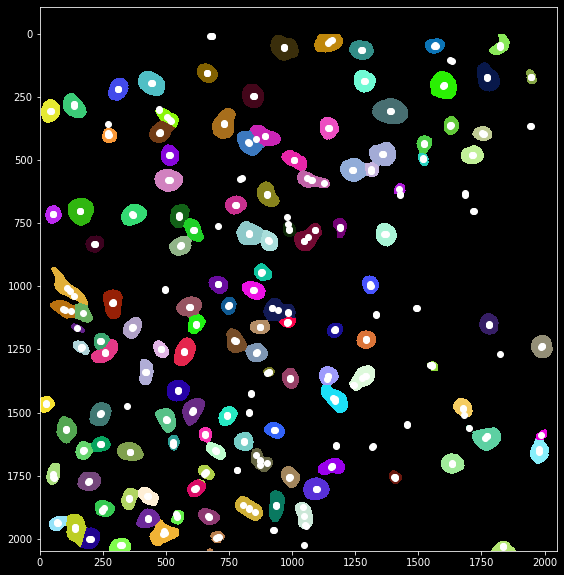

In [54]:
from fish_helpers import colorize_segmented_image
coord = mask_df.drop(columns = [i for i in mask_df.columns if not i in ['xc','yc','zc']])
cell_radius = 5 #um
db = DBSCAN(eps=2*cell_radius).fit(coord)
plt.figure(figsize=[10,10])
plt.imshow(colorize_segmented_image(mask_2d))
m = mask_df['zi'].isin(range(z-2,z+2))
plt.scatter(mask_df['yi'][m],mask_df['xi'][m],c='w')
plt.show()

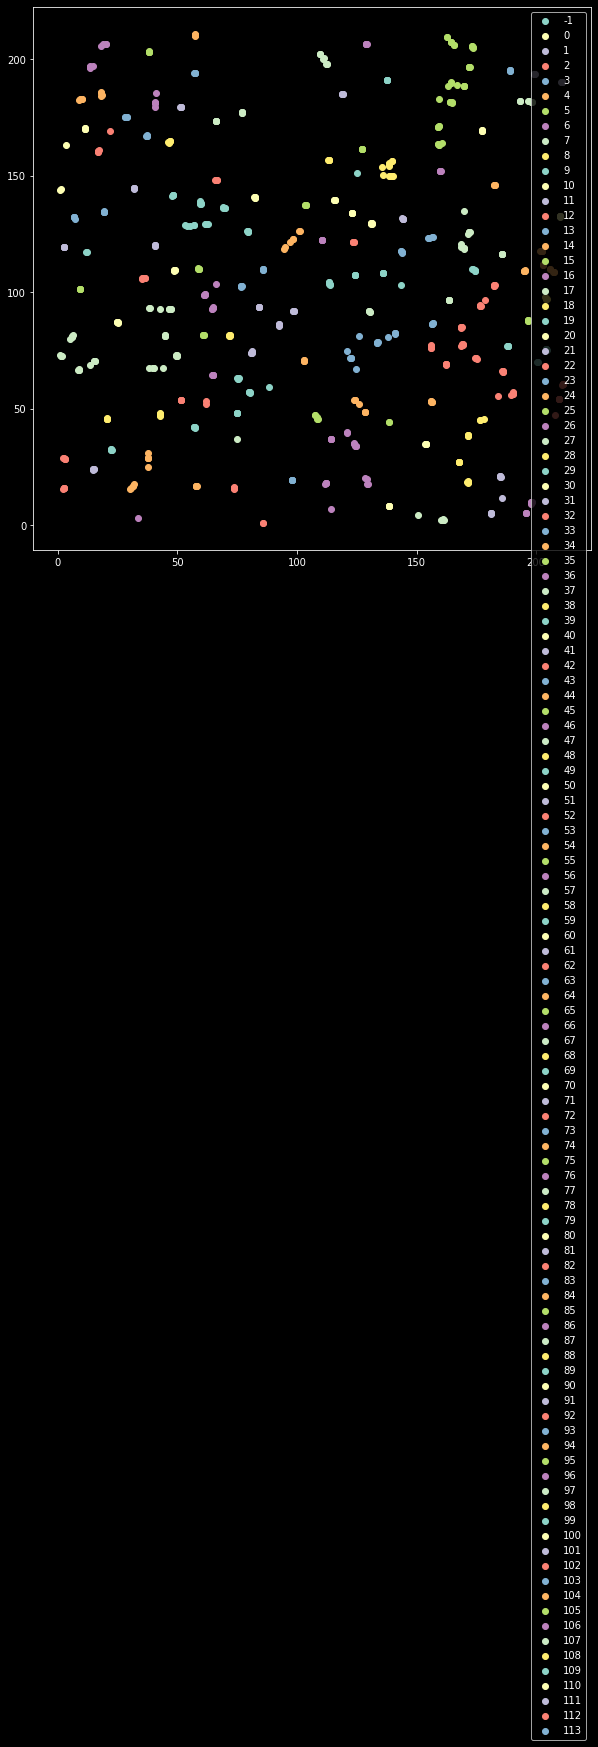

In [61]:
import matplotlib.pyplot as plt
coord = mask_df.drop(columns = [i for i in mask_df.columns if not i in ['xc','yc']])
cell_radius = 8 #um
db = DBSCAN(eps=cell_radius,algorithm='kd_tree').fit(coord)
plt.figure(figsize=[10,10])
for l in np.unique(db.labels_):
    m = (db.labels_==l)&(mask_df['zi'].isin(range(5,10)))
    plt.scatter(mask_df['xc'][m],mask_df['yc'][m],label=l)
plt.legend()
plt.show()

In [83]:
from skimage.external import tifffile
from ipypb import ipb
mask_stk_path = '/bigstore/Images2020/Zach/Cellpose_Hippocampus_test/Pos175/mask_stk.tif'
mask_stk = np.swapaxes(tifffile.imread(mask_stk_path),0,2)
from scipy.ndimage.morphology import binary_erosion
eroded_mask_stk = np.empty(mask.shape)
for z in ipb(range(mask_stk.shape[2])):
    mask_2d = mask_stk[:,:,z]
    eroded_2d = np.empty(mask_2d.shape)
    for label in ipb(np.unique(mask_2d.ravel()),desc='inner',leave=False):
        label_mask = mask_2d==label
        eroded = binary_erosion(label_mask,iterations=3)
        eroded_2d[eroded==1] = label
    eroded_mask_stk[:,:,z] = eroded_2d

 [████████████████████████████████████████████████████████████] 32/32 [03:27<00:05, 6.46s/it]

          inner [█████████████████████████████████████████████] 74/74 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 75/75 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 75/75 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 71/71 [00:05<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 73/73 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 80/80 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 87/87 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 89/89 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 89/89 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 93/93 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 93/93 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 92/92 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 93/93 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 90/90 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 89/89 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 91/91 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 92/92 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 85/85 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 89/89 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 88/88 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 84/84 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 84/84 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 86/86 [00:07<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 82/82 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 84/84 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 85/85 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 79/79 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 79/79 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 73/73 [00:06<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 70/70 [00:05<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 69/69 [00:05<00:00, 0.08s/it]

          inner [█████████████████████████████████████████████] 57/57 [00:04<00:00, 0.08s/it]

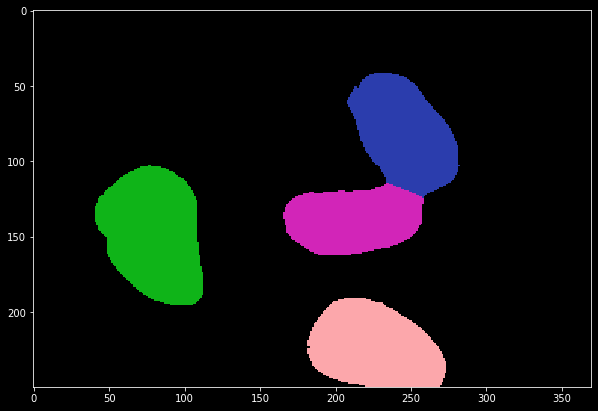

In [78]:
from fish_helpers import colorize_segmented_image
plt.figure(figsize=[10,10])
plt.imshow(colorize_segmented_image(mask_2d[1500:1750,750:1120]))
plt.show()

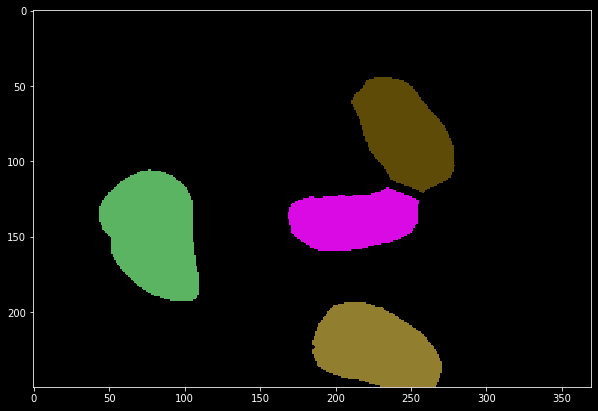

In [80]:
plt.figure(figsize=[10,10])
plt.imshow(colorize_segmented_image(eroded_2d[1500:1750,750:1120].astype('uint16')))
plt.show()

In [84]:
from skimage.measure import label, regionprops
mask_stk_path_out = '/bigstore/Images2020/Zach/Cellpose_Hippocampus_test/Pos175/updated_mask_stk.tif'
binary_eroded_mask_stk = eroded_mask_stk>0
labeled_eroded_mask_stk = label(binary_eroded_mask_stk)
tifffile.imsave(mask_stk_path_out, np.swapaxes(labeled_eroded_mask_stk,0,2).astype('uint16'))

In [87]:
md_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/'
meta = pd.read_csv(os.path.join(md_path,'hybe6_11','Metadata.txt'),index_col=0,sep='\t')
meta

,df_pos,linescan,Position,group,acq,frame,TimestampImage,XY,PixelSize,PlateType,Z,Zindex,XYbeforeTransform,Exposure,Channel,Triggered,Skip,TimestampFrame,filename
FlatField,,,,,,,,,,,,,,,,,,,
NaN,0,NaN,Pos1,Pos1,hybe6_11,1,737736.244024,2411 -3087,0.1032,Robs PDMS,3086.998,1,2411.025 -3086.5375,350,FarRed,False,1,737736.244032,Pos0/img_Pos1_000000001_000000000_FarRed_000_0...
NaN,0,NaN,Pos1,Pos1,hybe6_11,1,737736.244033,2411 -3087,0.1032,Robs PDMS,3086.998,1,2411.025 -3086.5375,300,Orange,False,1,737736.244032,Pos0/img_Pos1_000000001_000000000_Orange_000_0...
NaN,0,NaN,Pos1,Pos1,hybe6_11,1,737736.244039,2411 -3087,0.1032,Robs PDMS,3086.998,1,2411.025 -3086.5375,40,DeepBlue,False,1,737736.244032,Pos0/img_Pos1_000000001_000000000_DeepBlue_000...
NaN,0,NaN,Pos1,Pos1,hybe6_11,1,737736.244049,2411 -3087,0.1032,Robs PDMS,3087.564,2,2411.025 -3086.5375,350,FarRed,False,1,737736.244056,Pos0/img_Pos1_000000002_000000000_FarRed_000_0...
NaN,0,NaN,Pos1,Pos1,hybe6_11,1,737736.244057,2411 -3087,0.1032,Robs PDMS,3087.564,2,2411.025 -3086.5375,300,Orange,False,1,737736.244056,Pos0/img_Pos1_000000002_000000000_Orange_000_0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0,NaN,Pos8,Pos8,hybe6_11,1,737736.491818,2622 -3087,0.1032,Robs PDMS,3101.963,31,2621.95 -3086.5375,300,Orange,False,1,737736.491817,Pos301/img_Pos8_000000031_000000000_Orange_000...
NaN,0,NaN,Pos8,Pos8,hybe6_11,1,737736.491823,2622 -3087,0.1032,Robs PDMS,3101.963,31,2621.95 -3086.5375,40,DeepBlue,False,1,737736.491817,Pos301/img_Pos8_000000031_000000000_DeepBlue_0...
NaN,0,NaN,Pos8,Pos8,hybe6_11,1,737736.491835,2622 -3087,0.1032,Robs PDMS,3102.530,32,2621.95 -3086.5375,350,FarRed,False,1,737736.491843,Pos301/img_Pos8_000000032_000000000_FarRed_000...


In [92]:
from ipypb import ipb
filenames = []
for i,row in ipb(meta.iterrows(),len(meta)):
    pos = row.Position
    z = row.Zindex
    filenames.append(os.path.join(pos,pos+'_mask_z_'+str(z)+'.tif'))
filenames

 [████████████████████████████████████████████████████████████] 28800/28800 [00:08<00:00, 0.00s/it]

['Pos1/Pos1_mask_z_1.tif',
 'Pos1/Pos1_mask_z_1.tif',
 'Pos1/Pos1_mask_z_1.tif',
 'Pos1/Pos1_mask_z_2.tif',
 'Pos1/Pos1_mask_z_2.tif',
 'Pos1/Pos1_mask_z_2.tif',
 'Pos1/Pos1_mask_z_3.tif',
 'Pos1/Pos1_mask_z_3.tif',
 'Pos1/Pos1_mask_z_3.tif',
 'Pos1/Pos1_mask_z_4.tif',
 'Pos1/Pos1_mask_z_4.tif',
 'Pos1/Pos1_mask_z_4.tif',
 'Pos1/Pos1_mask_z_5.tif',
 'Pos1/Pos1_mask_z_5.tif',
 'Pos1/Pos1_mask_z_5.tif',
 'Pos1/Pos1_mask_z_6.tif',
 'Pos1/Pos1_mask_z_6.tif',
 'Pos1/Pos1_mask_z_6.tif',
 'Pos1/Pos1_mask_z_7.tif',
 'Pos1/Pos1_mask_z_7.tif',
 'Pos1/Pos1_mask_z_7.tif',
 'Pos1/Pos1_mask_z_8.tif',
 'Pos1/Pos1_mask_z_8.tif',
 'Pos1/Pos1_mask_z_8.tif',
 'Pos1/Pos1_mask_z_9.tif',
 'Pos1/Pos1_mask_z_9.tif',
 'Pos1/Pos1_mask_z_9.tif',
 'Pos1/Pos1_mask_z_10.tif',
 'Pos1/Pos1_mask_z_10.tif',
 'Pos1/Pos1_mask_z_10.tif',
 'Pos1/Pos1_mask_z_11.tif',
 'Pos1/Pos1_mask_z_11.tif',
 'Pos1/Pos1_mask_z_11.tif',
 'Pos1/Pos1_mask_z_12.tif',
 'Pos1/Pos1_mask_z_12.tif',
 'Pos1/Pos1_mask_z_12.tif',
 'Pos1/Pos1_mask_z_

In [ ]:
dictionary = {'img':img,'pos':pos,'z':z,'pos_path':pos_path}
dictionary['img']

In [ ]:
acqs = []
for acq in md.acqnames:
    if 'nucstain' in acq:
        acqs.append(acq)

In [ ]:
# Whole Experiment Segmentation Function
# Load Metadata
from metadata import Metadata
import pandas as pd
import os
md_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/'
md = Metadata(md_path)
new_acq = 'mask_v2'
acq = [ i for i in md.acqnames if ('nucstain' in i)][0]
poses = md.image_table[md.image_table.acq==acq].Position.unique()
meta = pd.read_csv(os.path.join(md_path,acq,'Metadata.txt'),index_col=0,sep='\t')
zindexes = meta.Zindex.unique()

# Create Dir for masks
mask_dir = os.path.join(md_path,new_acq)
if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)
# else:
#     raise(NameError('Directory already Exists'))
    
# Treat dir as acq create metadata for access later
meta['acq'] = new_acq
from ipypb import ipb
filenames = []
for i,row in meta.iterrows():
    pos = row.Position
    z = row.Zindex
    filenames.append(os.path.join(pos,pos+'_mask_z_'+str(z)+'.tif'))
meta['filename'] = filenames
meta.to_csv(os.path.join(mask_dir,'Metadata.txt'),sep='\t')

# Segment function
from cellpose import models
from skimage.external import tifffile
from collections import Counter
from scipy.ndimage.filters import gaussian_filter
import numpy as np
def segment(data):
    img = data['img']
    bkg = gaussian_filter(img,40)
    bkg_sub = img/bkg
    pos = data['pos']
    z = data['z']
    pos_path = data['pos_path']
    model = models.Cellpose(model_type="nuclei",gpu=False,batch_size=150)
    masks,flows,styles,diams = model.eval([bkg_sub],diameter=90.0,channels = [0,0],flow_threshold=1, cellprob_threshold=0)
    mask = masks[0]
#     for label,num in Counter(mask[mask>0].ravel()).items():
#         if num<1000:
#             loc = np.where(mask==label)
#             x = loc[0]
#             y = loc[1]
#             mask[x,y]=0
    fname = pos+'_mask_z_'+str(z)+'.tif'
    tifffile.imsave(os.path.join(pos_path,fname), mask.astype('uint16'))

# Segment
import multiprocessing
import sys
from ipypb import ipb
for pos in ipb(poses,desc='Total'):
    Input = []
    pos_path = os.path.join(md_path,new_acq,pos)
    if not os.path.exists(pos_path):
        os.mkdir(pos_path)
    for z in zindexes:
        img = md.stkread(Position=pos,Channel='DeepBlue',acq=acq,Zindex=z)
        Input.append({'img':img,'pos':pos,'z':z,'pos_path':pos_path})
    ncpu = 16
    with multiprocessing.Pool(ncpu) as ppool:
        sys.stdout.flush()
        for i in ipb(ppool.imap(segment, Input),len(Input),desc=pos):
            a=1
        ppool.close()
        sys.stdout.flush()

          Total [███████######################################] 51/300 [04:12:36<04:16, 297.17s/it]

opening img_Pos1_000000032_000000000_DeepBlue_000_032.tif

           Pos1 [█████████████████████████████████████████████] 32/32 [06:03<00:00, 11.35s/it]

opening img_Pos2_000000032_000000000_DeepBlue_000_032.tif

           Pos2 [█████████████████████████████████████████████] 32/32 [04:47<00:00, 8.97s/it]

opening img_Pos9_000000032_000000000_DeepBlue_000_032.tif

           Pos9 [█████████████████████████████████████████████] 32/32 [04:39<00:07, 8.73s/it]

opening img_Pos3_000000032_000000000_DeepBlue_000_032.tif

           Pos3 [█████████████████████████████████████████████] 32/32 [04:21<00:00, 8.17s/it]

opening img_Pos10_000000032_000000000_DeepBlue_000_032.tif

          Pos10 [█████████████████████████████████████████████] 32/32 [05:15<00:00, 9.85s/it]

opening img_Pos19_000000032_000000000_DeepBlue_000_032.tif

          Pos19 [█████████████████████████████████████████████] 32/32 [04:38<00:00, 8.70s/it]

opening img_Pos34_000000032_000000000_DeepBlue_000_032.tif

          Pos34 [█████████████████████████████████████████████] 32/32 [04:26<00:09, 8.30s/it]

opening img_Pos51_000000032_000000000_DeepBlue_000_032.tif

          Pos51 [█████████████████████████████████████████████] 32/32 [04:48<00:00, 9.01s/it]

opening img_Pos35_000000032_000000000_DeepBlue_000_032.tif

          Pos35 [█████████████████████████████████████████████] 32/32 [05:10<00:00, 9.69s/it]

opening img_Pos20_000000032_000000000_DeepBlue_000_032.tif

          Pos20 [█████████████████████████████████████████████] 32/32 [05:09<00:09, 9.65s/it]

opening img_Pos21_000000032_000000000_DeepBlue_000_032.tif

          Pos21 [█████████████████████████████████████████████] 32/32 [04:53<00:00, 9.14s/it]

opening img_Pos36_000000032_000000000_DeepBlue_000_032.tif

          Pos36 [█████████████████████████████████████████████] 32/32 [04:41<00:05, 8.79s/it]

opening img_Pos37_000000032_000000000_DeepBlue_000_032.tif

          Pos37 [█████████████████████████████████████████████] 32/32 [04:34<00:00, 8.55s/it]

opening img_Pos22_000000032_000000000_DeepBlue_000_032.tif

          Pos22 [█████████████████████████████████████████████] 32/32 [07:00<00:00, 13.14s/it]

opening img_Pos23_000000032_000000000_DeepBlue_000_032.tif

          Pos23 [█████████████████████████████████████████████] 32/32 [05:21<00:00, 10.03s/it]

opening img_Pos38_000000032_000000000_DeepBlue_000_032.tif

          Pos38 [█████████████████████████████████████████████] 32/32 [05:34<00:00, 10.43s/it]

opening img_Pos39_000000032_000000000_DeepBlue_000_032.tif

          Pos39 [█████████████████████████████████████████████] 32/32 [05:55<00:00, 11.09s/it]

opening img_Pos24_000000032_000000000_DeepBlue_000_032.tif

          Pos24 [█████████████████████████████████████████████] 32/32 [05:19<00:00, 9.98s/it]

opening img_Pos40_000000032_000000000_DeepBlue_000_032.tif

          Pos40 [█████████████████████████████████████████████] 32/32 [05:04<00:00, 9.51s/it]

opening img_Pos41_000000032_000000000_DeepBlue_000_032.tif

          Pos41 [█████████████████████████████████████████████] 32/32 [05:08<00:00, 9.63s/it]

opening img_Pos55_000000032_000000000_DeepBlue_000_032.tif

          Pos55 [█████████████████████████████████████████████] 32/32 [04:40<00:00, 8.75s/it]

opening img_Pos72_000000032_000000000_DeepBlue_000_032.tif

          Pos72 [█████████████████████████████████████████████] 32/32 [04:07<00:00, 7.70s/it]

opening img_Pos73_000000032_000000000_DeepBlue_000_032.tif

          Pos73 [█████████████████████████████████████████████] 32/32 [04:14<00:00, 7.93s/it]

opening img_Pos56_000000032_000000000_DeepBlue_000_032.tif

          Pos56 [█████████████████████████████████████████████] 32/32 [06:29<00:00, 12.16s/it]

opening img_Pos57_000000032_000000000_DeepBlue_000_032.tif

          Pos57 [█████████████████████████████████████████████] 32/32 [05:31<00:00, 10.36s/it]

opening img_Pos74_000000032_000000000_DeepBlue_000_032.tif

          Pos74 [█████████████████████████████████████████████] 32/32 [05:39<00:00, 10.59s/it]

opening img_Pos58_000000032_000000000_DeepBlue_000_032.tif

          Pos58 [█████████████████████████████████████████████] 32/32 [05:36<00:00, 10.51s/it]

opening img_Pos75_000000032_000000000_DeepBlue_000_032.tif

          Pos75 [█████████████████████████████████████████████] 32/32 [06:45<00:00, 12.66s/it]

opening img_Pos76_000000032_000000000_DeepBlue_000_032.tif

          Pos76 [█████████████████████████████████████████████] 32/32 [05:04<00:00, 9.48s/it]

opening img_Pos93_000000032_000000000_DeepBlue_000_032.tif

          Pos93 [█████████████████████████████████████████████] 32/32 [05:16<00:02, 9.88s/it]

opening img_Pos92_000000032_000000000_DeepBlue_000_032.tif

          Pos92 [█████████████████████████████████████████████] 32/32 [05:59<00:00, 11.23s/it]

opening img_Pos91_000000032_000000000_DeepBlue_000_032.tif

          Pos91 [█████████████████████████████████████████████] 32/32 [04:13<00:00, 7.90s/it]

opening img_Pos90_000000032_000000000_DeepBlue_000_032.tif

          Pos90 [█████████████████████████████████████████████] 32/32 [04:16<00:00, 8.01s/it]

opening img_Pos106_000000032_000000000_DeepBlue_000_032.tif

         Pos106 [█████████████████████████████████████████████] 32/32 [04:18<00:00, 8.05s/it]

opening img_Pos107_000000032_000000000_DeepBlue_000_032.tif

         Pos107 [█████████████████████████████████████████████] 32/32 [04:07<00:04, 7.71s/it]

opening img_Pos108_000000032_000000000_DeepBlue_000_032.tif

         Pos108 [█████████████████████████████████████████████] 32/32 [04:38<00:00, 8.67s/it]

opening img_Pos109_000000032_000000000_DeepBlue_000_032.tif

         Pos109 [█████████████████████████████████████████████] 32/32 [05:40<00:01, 10.64s/it]

opening img_Pos110_000000032_000000000_DeepBlue_000_032.tif

         Pos110 [█████████████████████████████████████████████] 32/32 [04:53<00:00, 9.17s/it]

opening img_Pos127_000000032_000000000_DeepBlue_000_032.tif

         Pos127 [█████████████████████████████████████████████] 32/32 [05:00<00:03, 9.39s/it]

opening img_Pos126_000000032_000000000_DeepBlue_000_032.tif

         Pos126 [█████████████████████████████████████████████] 32/32 [04:58<00:00, 9.31s/it]

opening img_Pos125_000000032_000000000_DeepBlue_000_032.tif

         Pos125 [█████████████████████████████████████████████] 32/32 [04:05<00:00, 7.66s/it]

opening img_Pos124_000000032_000000000_DeepBlue_000_032.tif

         Pos124 [█████████████████████████████████████████████] 32/32 [04:12<00:00, 7.88s/it]

opening img_Pos123_000000032_000000000_DeepBlue_000_032.tif

         Pos123 [█████████████████████████████████████████████] 32/32 [04:02<00:01, 7.55s/it]

opening img_Pos139_000000032_000000000_DeepBlue_000_032.tif

         Pos139 [█████████████████████████████████████████████] 32/32 [04:04<00:00, 7.64s/it]

opening img_Pos155_000000032_000000000_DeepBlue_000_032.tif

         Pos155 [█████████████████████████████████████████████] 32/32 [04:02<00:00, 7.57s/it]

opening img_Pos156_000000032_000000000_DeepBlue_000_032.tif

         Pos156 [█████████████████████████████████████████████] 32/32 [04:04<00:00, 7.63s/it]

opening img_Pos140_000000032_000000000_DeepBlue_000_032.tif

         Pos140 [█████████████████████████████████████████████] 32/32 [04:11<00:05, 7.85s/it]

opening img_Pos141_000000032_000000000_DeepBlue_000_032.tif

         Pos141 [█████████████████████████████████████████████] 32/32 [04:17<00:03, 8.04s/it]

opening img_Pos157_000000032_000000000_DeepBlue_000_032.tif

         Pos157 [█████████████████████████████████████████████] 32/32 [04:38<00:00, 8.68s/it]

opening img_Pos158_000000032_000000000_DeepBlue_000_032.tif

         Pos158 [█████████████████████████████████████████████] 32/32 [04:16<00:09, 7.99s/it]

opening img_Pos142_000000032_000000000_DeepBlue_000_032.tif

         Pos142 [█████████████████████████████████████████████] 32/32 [04:13<00:06, 7.91s/it]

opening img_Pos143_000000032_000000000_DeepBlue_000_032.tif

         Pos143 [█############################################] 1/32 [02:27<02:27, 147.39s/it]

In [ ]:
# Whole Experiment Segmentation Function
# Load Metadata
from metadata import Metadata
import pandas as pd
import os
md_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/'
md = Metadata(md_path)
acq = [ i for i in md.acqnames if ('nucstain' in i)][0]
poses = md.image_table[md.image_table.acq==acq].Position.unique()
meta = pd.read_csv(os.path.join(md_path,acq,'Metadata.txt'),index_col=0,sep='\t')
zindexes = meta.Zindex.unique()

# Create Dir for masks
mask_dir = os.path.join(md_path,'mask')
if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)
# else:
#     raise(NameError('Directory already Exists'))
    
# Treat dir as acq create metadata for access later
meta['acq'] = 'mask'
from ipypb import ipb
filenames = []
for i,row in meta.iterrows():
    pos = row.Position
    z = row.Zindex
    filenames.append(os.path.join(pos,pos+'_mask_z_'+str(z)+'.tif'))
meta['filename'] = filenames
meta.to_csv(os.path.join(mask_dir,'Metadata.txt'),sep='\t')

# Segment function
from cellpose import models
from skimage.external import tifffile
from collections import Counter
import numpy as np
def segment(data):
    md = data['md']
    acq = data['acq']
    pos = data['pos']
    stk = md.stkread(Position=pos,Channel='DeepBlue',acq=acq)
    pos_path = data['pos_path']
    model = models.Cellpose(model_type="nuclei",gpu=False,batch_size=150)
    imgs = [stk[:,:,z] for z in range(stk.shape[2])]
    masks,flows,styles,diams = model.eval(imgs,diameter=90.0,channels = [0,0],flow_threshold=1, cellprob_threshold=0)
    for z,mask in enumerate(masks):
        mask = masks[0]
        for label,num in Counter(mask[mask>0].ravel()).items():
            if num<1000:
                loc = np.where(mask==label)
                x = loc[0]
                y = loc[1]
                mask[x,y]=0
        fname = pos+'_mask_z_'+str(z)+'.tif'
        tifffile.imsave(os.path.join(pos_path,fname), mask.astype('uint16'))

# Segment
import multiprocessing
import sys
from ipypb import ipb
Input = []
for pos in poses:
    pos_path = os.path.join(md_path,'mask',pos)
    if not os.path.exists(pos_path):
        os.mkdir(pos_path)
    Input.append({'md':md,'pos':pos,'pos_path':pos_path,'acq':acq})
    
ncpu = 15
with multiprocessing.Pool(ncpu) as ppool:
    sys.stdout.flush()
    for i in ipb(ppool.imap(segment, Input),len(Input),desc='Segmentation'):
        a=1
    ppool.close()
    sys.stdout.flush()

   Segmentation [#############################################] 0/300 [0<0, 0.00s/it]

opening img_Pos23_000000032_000000000_DeepBlue_000_032.tif

Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/home/zach/miniconda3/envs/cellpose_v1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/zach/miniconda3/envs/cellpose_v1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/cellpose_v1/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-1-ecb806960623>", line 44, in segment
    masks,flows,styles,diams = model.eval(imgs,diameter=90.0,channels = [0,0],flow_threshold=1, cellprob_threshold=0)
  File "/home/zach/PythonRepos/cellpose/cellpose/models.py", line 183, in eval
    flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)
  File "/home/zach/PythonRepos/cellpose/cellpose/models.py", line 365, in eval
    y, style = self._run_many(img, rescale[i], tile)
  File "/home/zach/PythonRepos/cellpose/cellp

In [ ]:
from metadata import Metadata
from ipypb import ipb
from scipy.ndimage.filters import gaussian_filter
from cellpose import models
from skimage.external import tifffile
from collections import Counter
import multiprocessing
import os
import numpy as np
import sys
import time
import random
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
out_dir = '/bigstore/Images2020/Zach/Cellpose_Hippocampus_test'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
md_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/'
md = Metadata(md_path)
acqs = [ i for i in md.acqnames if ('hybe' in i)|('nucstain' in i)]
poses = md.image_table[md.image_table.acq.isin(acqs)].Position.unique()
Input = []
used_poses = []
for i in range(100):
    pos = random.choice(poses)
    while (os.path.exists(os.path.join(out_dir,pos)))|(pos in used_poses):
        pos = random.choice(poses)
    used_poses.append(pos)
    acq = [i for i in acqs if 'nucstain' in i]
    stk = md.stkread(Position=pos,Channel='DeepBlue',acq=acq)
    Input.append({'stk':stk,'pos_path':os.path.join(out_dir,pos)})

def wrapper(data):
    stk = data['stk']
    pos_path = data['pos_path']
    imgs = []
    for z in range(stk.shape[2]):
        img = stk[:,:,z]
        bkg = gaussian_filter(img,40)
        bkg_sub = img/bkg
        imgs.append(bkg_sub)
    mask_stk = np.empty(stk.shape)
    model = models.Cellpose(model_type="nuclei",gpu=True,batch_size=150)
    masks,flows,styles,diams = model.eval(imgs,diameter=90.0,channels = [0,0],flow_threshold=1, cellprob_threshold=0)
    for z in range(len(masks)):
        mask = masks[z].copy()
        for label,num in Counter(mask[mask>0].ravel()).items():
            if num<1000:
                loc = np.where(mask==label)
                x = loc[0]
                y = loc[1]
                mask[x,y]=0
        mask_stk[:,:,z] = mask
    if not os.path.exists(pos_path):
        os.mkdir(pos_path)
    tifffile.imsave(os.path.join(pos_path,'stk.tif'), np.swapaxes(stk,0,2).astype('uint16'))
    tifffile.imsave(os.path.join(pos_path,'mask_stk.tif'), np.swapaxes(mask_stk,0,2).astype('uint16'))
    return None
ncpu = 6
with multiprocessing.Pool(ncpu) as ppool:
    sys.stdout.flush()
    for i in ipb(ppool.imap(wrapper, Input),len(Input)):
        a=1
    ppool.close()
    sys.stdout.flush()